In [13]:
import dbconnect
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
data1=dbconnect.get_data()

In [15]:
data1['month']=data1.date.dt.month
data1['weekday_name']=data1.date.dt.weekday_name
data1['day_of_month']=data1.date.dt.days_in_month

In [21]:
data=data1[data1.user_id=='auth0|5a79f5c4ed65e34236bd7800']

In [24]:
class DateSelectionMethod:
    def __init__(self):
        pass
    def transaction_matching(self, transaction):
        return transaction
    def transaction_matches_date(self, transaction):
        return True
    def display(self):
        return 'Occurs in this dataset'
    def first_time_after(self, given_date):
        return given_date + datetime.timedelta(day=1)

In [25]:
class DayOfMonthSelectionMethod(DateSelectionMethod):
    def __init__(self, day_of_month):
        DateSelectionMethod.__init__(self)
        self._day_of_month = day_of_month
    def transaction_matching(self, transaction):
        return transaction[transaction.day_of_month == self._day_of_month]
    def display(self):
        return "Occurs on the %d of the month" % (self._day_of_month)
    def first_time_after(self, some_date):
        d = some_date
        while d.day != self._day_of_month:
            d += datetime.timedelta(days=1)
        return d

In [26]:
class DayOfWeekSelectionMethod(DateSelectionMethod):
    def __init__(self, day_of_week):
        DateSelectionMethod.__init__(self)
        self._day_of_week = day_of_week
    def transaction_matching(self, transaction):
        return transaction[transaction.weekday_name == self._day_of_week]
    def display(self):
        return "Occurs on a " + self._day_of_week
    def first_time_after(self, some_date):
        d = some_date
        while d.strftime("%A") != self._day_of_week:
            d += datetime.timedelta(days=1)
        return d

In [27]:
class LastDayOfMonthSelectionMethod(DateSelectionMethod):
    def __init__(self):
        DateSelectionMethod.__init__(self)
    def transaction_matching(self, transaction):
        def is_last_day(x):
            if x.month in [9,4,6,11] and x.day == 30: return True
            if x.month in [1,3,5,7,8,10,12] and x.day == 31: return True
            if x.month == 2 and x.year % 4 == 0 and x.day == 29: return True
            if x.month == 2 and x.year % 4 != 0 and x.day == 28: return True
            return False
        return transaction[transaction.date.map(is_last_day)]
    def display(self):
        return "Occurs on the last day of the month"
    def first_time_after(self, some_date):
        d = some_date
        while d.day != 1:
            d += datetime.timedelta(days=1)
        return d - datetime.timedelta(days=1)

In [28]:
def descriptions_of_encore_transaction(date_selection_method):
    matching = date_selection_method.transaction_matching(data)
    descriptions = matching.groupby('description').size()
    descriptions = descriptions[descriptions > 1]
    for d in descriptions.index:
        matching_that_description = data[data.description == d]
        if date_selection_method.transaction_matching(matching_that_description).shape == matching_that_description.shape:
            yield d
        
def recurring_transaction(date_selection_method):
    for d in descriptions_of_encore_transaction(date_selection_method):
        recurring = data[data.description == d].sort_values('date', ascending=False).head(3)
        if recurring.amount.nunique() == 1:
            yield recurring

In [29]:
for transaction_group in recurring_transaction(DayOfMonthSelectionMethod(1)):
    print(transaction_group)

In [30]:
for transaction_group in recurring_transaction(DayOfWeekSelectionMethod('Monday')):
    print(transaction_group)

In [31]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day in weekdays:
    for transaction_group in recurring_transaction(DayOfWeekSelectionMethod(day)):
        print(day, transaction_group)

Thursday                          date  amount  \
421 2016-10-20 00:00:00+00:00   -50.0   
368 2016-10-06 00:00:00+00:00   -50.0   

                                   description  \
421  ATM Cash 2621 PHILA PIKE CLAYMONT DE 9079   
368  ATM Cash 2621 PHILA PIKE CLAYMONT DE 9079   

                         account_name account_type  \
421  Circle Gold Checking w/ Interest   depository   
368  Circle Gold Checking w/ Interest   depository   

                            user_id account_subtype  \
421  auth0|5a79f5c4ed65e34236bd7800        checking   
368  auth0|5a79f5c4ed65e34236bd7800        checking   

                                        account_number      bank_name  \
421  [b'8', b'\xfd', b'\xe2', b'\xae', b'e', b'\x98...  Citizens Bank   
368  [b'8', b'\xfd', b'\xe2', b'\xae', b'e', b'\x98...  Citizens Bank   

     category sub_category  lat long state  month weekday_name  day_of_month  
421  Transfer   Withdrawal  NaN  NaN   NaN     10     Thursday            31  
368  Tran

In [34]:
import datetime

In [35]:
data.date.dt.to_pydatetime()

array([datetime.datetime(2016, 2, 23, 0, 0, tzinfo=<UTC>),
       datetime.datetime(2016, 2, 29, 0, 0, tzinfo=<UTC>),
       datetime.datetime(2016, 2, 29, 0, 0, tzinfo=<UTC>), ...,
       datetime.datetime(2018, 2, 9, 0, 0, tzinfo=<UTC>),
       datetime.datetime(2018, 2, 13, 0, 0, tzinfo=<UTC>),
       datetime.datetime(2018, 2, 17, 0, 0, tzinfo=<UTC>)], dtype=object)

In [36]:
def one_month_before(some_date):
    if some_date.month == 1:
        return datetime.datetime(some_date.year-1, 12, some_date.day)
    else:
        return datetime.datetime(some_date.year, some_date.month-1, some_date.day)

def one_week_before(some_date):
    return some_date - datetime.timedelta(days=7)

In [37]:
def three_months_before(some_date):
    return one_month_before(one_month_before(one_month_before(some_date)))

def three_weeks_before(some_date):
    return one_week_before(one_week_before(one_week_before(some_date)))

In [38]:
def transactions_since(some_date):
    return data[data.date >= some_date]
def transactions_between(some_date, other_date):
    return data[(data.date >= some_date) & (data.date < other_date) ]

In [39]:
def transaction_buckets(period='months', end_time=None):
    if period == 'months':
        func = one_month_before
    elif period == 'weeks':
        func = one_week_before
    else:
        raise ValueError
    if end_time is None:
        end_time = datetime.datetime.now()
    back1 = func(end_time)
    back2 = func(back1)
    back3 = func(back2)
    old_bucket = transactions_between(back3, back2)
    middle_bucket = transactions_between(back2, back1)
    new_bucket = transactions_between(back1, end_time)
    return [old_bucket, middle_bucket, new_bucket]
    

In [40]:
transaction_buckets()

[                          date   amount  \
 1623 2017-12-07 00:00:00+00:00   -36.69   
 1624 2017-12-07 00:00:00+00:00   -23.49   
 1625 2017-12-08 00:00:00+00:00   -50.00   
 1627 2017-12-08 00:00:00+00:00    50.00   
 1628 2017-12-08 00:00:00+00:00   340.57   
 1629 2017-12-11 00:00:00+00:00  -200.00   
 1630 2017-12-11 00:00:00+00:00   -18.36   
 1631 2017-12-11 00:00:00+00:00  5602.50   
 1633 2017-12-12 00:00:00+00:00 -4000.00   
 1634 2017-12-12 00:00:00+00:00  -700.00   
 1635 2017-12-12 00:00:00+00:00   -50.00   
 1636 2017-12-12 00:00:00+00:00    -5.00   
 1639 2017-12-12 00:00:00+00:00    30.00   
 1640 2017-12-13 00:00:00+00:00  -209.59   
 1641 2017-12-13 00:00:00+00:00   -53.03   
 1642 2017-12-13 00:00:00+00:00   -30.00   
 1644 2017-12-15 00:00:00+00:00  -173.00   
 1645 2017-12-15 00:00:00+00:00   -73.68   
 1646 2017-12-15 00:00:00+00:00   -49.95   
 1647 2017-12-15 00:00:00+00:00   -46.24   
 1648 2017-12-15 00:00:00+00:00    49.95   
 1651 2017-12-19 00:00:00+00:00 

In [41]:
def regular_transactions(period='months', end_time=None):
    [old_bucket, middle_bucket, new_bucket] = transaction_buckets(period, end_time)
    known_descriptions = set()
    for descr in old_bucket.description.unique():
        old_count = old_bucket[old_bucket.description == descr].description.count()
        middle_count = middle_bucket[middle_bucket.description == descr].description.count()
        new_count = new_bucket[new_bucket.description == descr].description.count()
        #print descr, old_count, middle_count, new_count
        if old_count == middle_count and middle_count == new_count:
            yield descr    

In [42]:
list(regular_transactions(end_time = datetime.datetime(2017,12,1)))

['Preauthorized Debit DISCOVER CARD ONLINE PMT',
 'Preauthorized Debit KEYSTONE HEALTH ONLINE PMT',
 'Preauthorized Debit CITIZENS BANK LOAN PYMNT',
 'Preauthorized Debit ERIE INS GROUP ERIEXPSPAY',
 'Preauthorized Debit AQUA AMERICA ONLINE PMT',
 'Preauthorized Debit VERIZON ONLINE PMT',
 'Preauthorized Debit CITIBANK CRDT CD ONLINE PMT',
 'Preauthorized Debit AT&T MOBILITY ONLINE PMT',
 'PAYMENT THANK YOU',
 'Preauthorized Debit PECO ENERGY ONLINE PMT',
 'Monthly Interest Paid']

In [44]:
list(regular_transactions(period = 'weeks', end_time = datetime.datetime(2017,12,1)))

['Preauthorized Deposit from CITIZENS BANK checking account XXXXXX7848',
 'Preauthorized Debit CAPITAL ONE N.A. CAPITALONE']

In [45]:
weekday_filters = [DayOfWeekSelectionMethod(x) for x in
                       ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
monthday_filters = [DayOfMonthSelectionMethod(x) for x in range(1,32)]
all_filters = weekday_filters + monthday_filters + [LastDayOfMonthSelectionMethod()]

In [46]:
periodic_descriptions = {}
for date_chooser in all_filters:
    for transaction in recurring_transaction(date_chooser):
        descr = transaction.description.unique()[0]
        transaction_date = transaction.date.dt.to_pydatetime()[0]
        print(transaction_date)
        periodic_descriptions[descr] = date_chooser.first_time_after(transaction_date)
other_regular_transactions = {}
for x in list(regular_transactions(period = 'weeks', end_time = datetime.datetime(2017,12,1))):
    other_regular_transactions[x] = "weekly"
for x in list(regular_transactions(period = 'months', end_time = datetime.datetime(2017,12,1))):
    other_regular_transactions[x] = "monthly"

2016-10-20 00:00:00+00:00
2017-08-31 00:00:00+00:00
2018-03-01 00:00:00+00:00
2018-02-28 00:00:00+00:00
2018-02-15 00:00:00+00:00
2018-02-26 00:00:00+00:00
2018-02-17 00:00:00+00:00
2018-02-21 00:00:00+00:00
2018-02-28 00:00:00+00:00
2018-02-21 00:00:00+00:00
2018-02-12 00:00:00+00:00
2016-10-20 00:00:00+00:00
2017-08-31 00:00:00+00:00
2018-03-02 00:00:00+00:00
2018-03-05 00:00:00+00:00
2018-01-23 00:00:00+00:00
2018-03-03 00:00:00+00:00


In [47]:
periodic_descriptions

{'ATM Cash 2621 PHILA PIKE CLAYMONT DE 9079': datetime.datetime(2016, 10, 31, 0, 0, tzinfo=<UTC>),
 'BOR.OF W. CHESTER': datetime.datetime(2018, 2, 28, 0, 0, tzinfo=<UTC>),
 'DBT Purchase PHYSICAL THERAPY PMECHANICSBURGPA 9079': datetime.datetime(2017, 8, 31, 0, 0, tzinfo=<UTC>),
 'DIG INN 70 PRI': datetime.datetime(2018, 3, 31, 0, 0, tzinfo=<UTC>),
 'DIG INN 70 PRINCE': datetime.datetime(2018, 3, 31, 0, 0, tzinfo=<UTC>),
 'Direct Deposit THE BANCORP BANK TRANSFER': datetime.datetime(2018, 1, 31, 0, 0, tzinfo=<UTC>),
 'Funds On Hold': datetime.datetime(2018, 2, 28, 0, 0, tzinfo=<UTC>),
 'HAND AND STONE': datetime.datetime(2018, 2, 28, 0, 0, tzinfo=<UTC>),
 'HEADQUARTERS H': datetime.datetime(2018, 2, 28, 0, 0, tzinfo=<UTC>),
 'HEADQUARTERS HAIR': datetime.datetime(2018, 2, 28, 0, 0, tzinfo=<UTC>),
 'PURE AND FRESH': datetime.datetime(2018, 3, 31, 0, 0, tzinfo=<UTC>),
 'Preauthorized Debit DENTEGRA INS': datetime.datetime(2018, 2, 28, 0, 0, tzinfo=<UTC>),
 'Preauthorized Debit KEYSTONE 

In [48]:
for d in periodic_descriptions.keys():
    print ( d, datetime.datetime.now())

ATM Cash 2621 PHILA PIKE CLAYMONT DE 9079 2018-03-05 15:31:37.152835
DBT Purchase PHYSICAL THERAPY PMECHANICSBURGPA 9079 2018-03-05 15:31:37.152977
Preauthorized Debit KEYSTONE HEALTH 2018-03-05 15:31:37.153044
BOR.OF W. CHESTER 2018-03-05 15:31:37.153112
Funds On Hold 2018-03-05 15:31:37.153178
HAND AND STONE 2018-03-05 15:31:37.153354
HEADQUARTERS H 2018-03-05 15:31:37.153422
HEADQUARTERS HAIR 2018-03-05 15:31:37.153489
Preauthorized Debit DENTEGRA INS 2018-03-05 15:31:37.156393
Preauthorized Debit THE BANCORP BAN 2018-03-05 15:31:37.156465
VIATOR/TRIPADVISOR 2018-03-05 15:31:37.156507
DIG INN 70 PRI 2018-03-05 15:31:37.156619
DIG INN 70 PRINCE 2018-03-05 15:31:37.156732
Direct Deposit THE BANCORP BANK TRANSFER 2018-03-05 15:31:37.156787
PURE AND FRESH 2018-03-05 15:31:37.156827


In [49]:
d= datetime.datetime.now()

In [50]:
d.strftime("%A")

'Monday'

In [51]:
other_regular_transactions

{'Monthly Interest Paid': 'monthly',
 'PAYMENT THANK YOU': 'monthly',
 'Preauthorized Debit AQUA AMERICA ONLINE PMT': 'monthly',
 'Preauthorized Debit AT&T MOBILITY ONLINE PMT': 'monthly',
 'Preauthorized Debit CAPITAL ONE N.A. CAPITALONE': 'weekly',
 'Preauthorized Debit CITIBANK CRDT CD ONLINE PMT': 'monthly',
 'Preauthorized Debit CITIZENS BANK LOAN PYMNT': 'monthly',
 'Preauthorized Debit DISCOVER CARD ONLINE PMT': 'monthly',
 'Preauthorized Debit ERIE INS GROUP ERIEXPSPAY': 'monthly',
 'Preauthorized Debit KEYSTONE HEALTH ONLINE PMT': 'monthly',
 'Preauthorized Debit PECO ENERGY ONLINE PMT': 'monthly',
 'Preauthorized Debit VERIZON ONLINE PMT': 'monthly',
 'Preauthorized Deposit from CITIZENS BANK checking account XXXXXX7848': 'weekly'}

In [52]:
data['PeriodicityTag'] = ""
for idx in data.index:
    descr = data.loc[idx, 'description']
    amount = data.loc[idx, 'amount']
    kind = 'income' if amount > 0 else 'expense'
    if descr in periodic_descriptions:
        data.loc[idx, 'PeriodicityTag'] = str(periodic_descriptions[descr]) + ' ' + kind

    elif descr in other_regular_transactions:
        data.loc[idx, 'PeriodicityTag'] = other_regular_transactions[descr] + ' ' + kind

/Users/shel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/shel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [53]:
data[data.PeriodicityTag != '']

date   amount  \
7    2016-02-23 00:00:00+00:00    30.00   
11   2016-02-29 00:00:00+00:00     0.61   
12   2016-02-29 00:00:00+00:00     0.92   
21   2016-03-08 00:00:00+00:00    30.00   
26   2016-03-21 00:00:00+00:00    50.00   
28   2016-03-22 00:00:00+00:00    30.00   
32   2016-03-31 00:00:00+00:00     0.83   
33   2016-03-31 00:00:00+00:00     1.02   
39   2016-04-05 00:00:00+00:00    30.00   
51   2016-04-19 00:00:00+00:00    30.00   
52   2016-04-19 00:00:00+00:00    50.00   
63   2016-04-30 00:00:00+00:00     0.93   
64   2016-04-30 00:00:00+00:00     1.03   
65   2016-05-03 00:00:00+00:00    30.00   
75   2016-05-17 00:00:00+00:00    30.00   
78   2016-05-19 00:00:00+00:00    50.00   
85   2016-05-31 00:00:00+00:00     1.10   
86   2016-05-31 00:00:00+00:00     1.11   
88   2016-05-31 00:00:00+00:00    30.00   
104  2016-06-14 00:00:00+00:00    30.00   
107  2016-06-20 00:00:00+00:00    50.00   
111  2016-06-28 00:00:00+00:00    30.00   
113  2016-06-30 00:00:00+00:00     1.11   
114  2016-06-30 00:00:00+00:00     1.23   
124  2016-07-12 00:00:00+00:00    30.00   
135  2016-07-19 00:00:00+00:00  -200.00   
136  2016-07-19 00:00:00+00:00  -188.00   
138  2016-07-19 00:00:00+00:00    50.00   
140  2016-07-20 00:00:00+00:00   -50.00   
155  2016-07-26 00:00:00+00:00   -30.51   
...                        ...      ...   
1867 2018-02-20 00:00:00+00:00  -200.00   
1869 2018-02-20 00:00:00+00:00   -85.00   
1870 2018-02-20 00:00:00+00:00    30.00   
1871 2018-02-20 00:00:00+00:00    50.00   
1873 2018-02-21 00:00:00+00:00  -700.00   
1875 2018-02-21 00:00:00+00:00   -85.00   
1877 2018-02-21 00:00:00+00:00   -50.00   
1879 2018-02-21 00:00:00+00:00   -30.00   
1901 2018-02-24 00:00:00+00:00   -59.95   
1903 2018-02-25 00:00:00+00:00   -59.95   
1906 2018-02-26 00:00:00+00:00   -59.95   
1913 2018-02-27 00:00:00+00:00    -1.50   
1922 2018-02-28 00:00:00+00:00   -19.49   
1924 2018-02-28 00:00:00+00:00    -1.50   
1926 2018-02-28 00:00:00+00:00     1.96   
1927 2018-02-28 00:00:00+00:00     2.52   
1931 2018-03-01 00:00:00+00:00  -569.44   
1932 2018-03-01 00:00:00+00:00  -569.44   
1933 2018-03-01 00:00:00+00:00   -13.00   
1934 2018-03-01 00:00:00+00:00    -8.14   
1941 2018-03-02 00:00:00+00:00 -1473.99   
1948 2018-03-02 00:00:00+00:00   -13.00   
1949 2018-03-02 00:00:00+00:00   -13.00   
1951 2018-03-02 00:00:00+00:00    -8.14   
1955 2018-03-03 00:00:00+00:00   -13.00   
1956 2018-03-03 00:00:00+00:00    -8.14   
1958 2018-03-04 00:00:00+00:00   -13.00   
1962 2018-03-05 00:00:00+00:00   -13.00   
2032 2018-02-12 00:00:00+00:00  -134.00   
2174 2018-02-09 00:00:00+00:00  -134.00   

                                            description  \
7     Preauthorized Deposit from CITIZENS BANK check...   
11                                Monthly Interest Paid   
12                                Monthly Interest Paid   
21    Preauthorized Deposit from CITIZENS BANK check...   
26    Preauthorized Deposit from CITIZENS BANK check...   
28    Preauthorized Deposit from CITIZENS BANK check...   
32                                Monthly Interest Paid   
33                                Monthly Interest Paid   
39    Preauthorized Deposit from CITIZENS BANK check...   
51    Preauthorized Deposit from CITIZENS BANK check...   
52    Preauthorized Deposit from CITIZENS BANK check...   
63                                Monthly Interest Paid   
64                                Monthly Interest Paid   
65    Preauthorized Deposit from CITIZENS BANK check...   
75    Preauthorized Deposit from CITIZENS BANK check...   
78    Preauthorized Deposit from CITIZENS BANK check...   
85                                Monthly Interest Paid   
86                                Monthly Interest Paid   
88    Preauthorized Deposit from CITIZENS BANK check...   
104   Preauthorized Deposit from CITIZENS BANK check...   
107   Preauthorized Deposit from CITIZENS BANK check...   
111   Preauthorized Deposit from CITIZENS BANK check...   
11

In [54]:
data.PeriodicityTag.unique()

array(['weekly income', 'monthly income', '', 'monthly expense',
       'weekly expense', '2016-10-31 00:00:00+00:00 expense',
       '2017-08-31 00:00:00+00:00 expense',
       '2018-01-31 00:00:00+00:00 income',
       '2018-03-01 00:00:00+00:00 expense',
       '2018-02-28 00:00:00+00:00 expense',
       '2018-03-31 00:00:00+00:00 expense'], dtype=object)

In [55]:
data[data.PeriodicityTag.str.contains('expense')]

date   amount  \
135  2016-07-19 00:00:00+00:00  -200.00   
136  2016-07-19 00:00:00+00:00  -188.00   
140  2016-07-20 00:00:00+00:00   -50.00   
155  2016-07-26 00:00:00+00:00   -30.51   
161  2016-07-27 00:00:00+00:00  -194.80   
162  2016-07-27 00:00:00+00:00   -30.00   
175  2016-08-02 00:00:00+00:00  -605.30   
181  2016-08-03 00:00:00+00:00   -75.58   
203  2016-08-10 00:00:00+00:00   -30.00   
214  2016-08-16 00:00:00+00:00  -403.91   
215  2016-08-16 00:00:00+00:00  -188.06   
218  2016-08-16 00:00:00+00:00   -60.01   
221  2016-08-17 00:00:00+00:00   -25.00   
224  2016-08-18 00:00:00+00:00  -167.00   
235  2016-08-22 00:00:00+00:00   -50.00   
245  2016-08-24 00:00:00+00:00   -30.00   
257  2016-09-02 00:00:00+00:00  -860.76   
264  2016-09-06 00:00:00+00:00   -75.58   
270  2016-09-07 00:00:00+00:00   -30.00   
283  2016-09-15 00:00:00+00:00  -189.00   
284  2016-09-15 00:00:00+00:00  -164.22   
285  2016-09-15 00:00:00+00:00   -28.96   
290  2016-09-16 00:00:00+00:00  -325.00   
310  2016-09-20 00:00:00+00:00   -50.00   
313  2016-09-21 00:00:00+00:00   -30.00   
342  2016-09-30 00:00:00+00:00  -140.86   
355  2016-10-03 00:00:00+00:00   -75.58   
359  2016-10-04 00:00:00+00:00   -35.00   
364  2016-10-05 00:00:00+00:00   -30.00   
368  2016-10-06 00:00:00+00:00   -50.00   
...                        ...      ...   
1858 2018-02-17 00:00:00+00:00   -85.00   
1859 2018-02-17 00:00:00+00:00   -85.00   
1861 2018-02-18 00:00:00+00:00   -85.00   
1863 2018-02-19 00:00:00+00:00   -85.00   
1867 2018-02-20 00:00:00+00:00  -200.00   
1869 2018-02-20 00:00:00+00:00   -85.00   
1873 2018-02-21 00:00:00+00:00  -700.00   
1875 2018-02-21 00:00:00+00:00   -85.00   
1877 2018-02-21 00:00:00+00:00   -50.00   
1879 2018-02-21 00:00:00+00:00   -30.00   
1901 2018-02-24 00:00:00+00:00   -59.95   
1903 2018-02-25 00:00:00+00:00   -59.95   
1906 2018-02-26 00:00:00+00:00   -59.95   
1913 2018-02-27 00:00:00+00:00    -1.50   
1922 2018-02-28 00:00:00+00:00   -19.49   
1924 2018-02-28 00:00:00+00:00    -1.50   
1931 2018-03-01 00:00:00+00:00  -569.44   
1932 2018-03-01 00:00:00+00:00  -569.44   
1933 2018-03-01 00:00:00+00:00   -13.00   
1934 2018-03-01 00:00:00+00:00    -8.14   
1941 2018-03-02 00:00:00+00:00 -1473.99   
1948 2018-03-02 00:00:00+00:00   -13.00   
1949 2018-03-02 00:00:00+00:00   -13.00   
1951 2018-03-02 00:00:00+00:00    -8.14   
1955 2018-03-03 00:00:00+00:00   -13.00   
1956 2018-03-03 00:00:00+00:00    -8.14   
1958 2018-03-04 00:00:00+00:00   -13.00   
1962 2018-03-05 00:00:00+00:00   -13.00   
2032 2018-02-12 00:00:00+00:00  -134.00   
2174 2018-02-09 00:00:00+00:00  -134.00   

                                          description  \
135        Preauthorized Debit PECO ENERGY ONLINE PMT   
136      Preauthorized Debit AT&T MOBILITY ONLINE PMT   
140   Preauthorized Debit CAPITAL ONE N.A. CAPITALONE   
155       Preauthorized Debit AQUA AMERICA ONLINE PMT   
161            Preauthorized Debit VERIZON ONLINE PMT   
162   Preauthorized Debit CAPITAL ONE N.A. CAPITALONE   
175      Preauthorized Debit DISCOVER CARD ONLINE PMT   
181     Preauthorized Debit ERIE INS GROUP ERIEXPSPAY   
203   Preauthorized Debit CAPITAL ONE N.A. CAPITALONE   
214            Preauthorized Debit VERIZON ONLINE PMT   
215      Preauthorized Debit AT&T MOBILITY ONLINE PMT   
218       Preauthorized Debit AQUA AMERICA ONLINE PMT   
221   Preauthorized Debit CITIBANK CRDT CD ONLINE PMT   
224        Preauthorized Debit PECO ENERGY ONLINE PMT   
235   Preauthorized Debit CAPITAL ONE N.A. CAPITALONE   
245   Preauthorized Debit CAPITAL ONE N.A. CAPITALONE   
257      Preauthorized Debit DISCOVER CARD ONLINE PMT   
264     Preauthorized Debit ERIE INS GROUP ERIEXPSPAY   
270   Preauthorized Debit CAPITAL ONE N.A. CAPITALONE   
283        Preauthorized Debit PECO ENERGY ONLINE PMT   
284      Preauthorized Debit AT&T MOBILITY ONLINE PMT   
285            Preauthorized Debit VERIZON ONLINE PMT   
290   Preauthorized Debit CITIBANK CRDT CD ONLIN

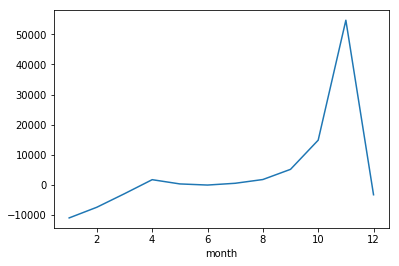

In [56]:
data[data.PeriodicityTag == ''].groupby('month').amount.sum().plot()

In [57]:
data[data.PeriodicityTag != ''].groupby(['category', 'month']).amount.sum()

category        month
Food and Drink  3           -78.00
Healthcare      8          -120.00
Interest        1            21.91
                2            18.67
                3            13.62
                4            11.11
                5            10.81
                6             8.89
                7             7.87
                8             7.10
                9             5.95
                10            5.99
                11            6.43
                12           22.31
NULL            1          -808.41
                2       -205523.67
                3         -2070.73
                4          -435.80
                5          -672.14
                6         -1106.52
                7          -464.65
                8          -897.34
                9          -858.42
                10         -887.26
                11         -857.51
                12         -917.22
Payment         1         -2887.57
                2         -1494.9

In [58]:
data[data.PeriodicityTag == ''].groupby(['category', 'month']).amount.sum()

category        month
Bank Fees       1          -15.00
                2           -9.00
                3           -3.00
                4           -9.00
                5           -3.00
                7           12.04
                8          572.67
                9          477.11
                12          86.63
Food and Drink  1         -190.16
                2         -345.39
                3          -44.26
                4         -164.90
                5          -76.83
                6         -222.27
                7         -331.46
                8          -66.48
                9          -93.54
                10        -125.40
                11         -92.51
                12        -176.72
Healthcare      6          -60.00
                7         -187.00
                8         -180.00
                10        -162.00
                11         -13.50
Interest        1           -3.45
                2            0.14
                3         

In [59]:
df = pandas.DataFrame({
    'stuff': data[data.PeriodicityTag == ''].groupby(['category', 'month']).amount.sum()
})
df.reset_index(inplace=True)
df

category  month     stuff
0         Bank Fees      1    -15.00
1         Bank Fees      2     -9.00
2         Bank Fees      3     -3.00
3         Bank Fees      4     -9.00
4         Bank Fees      5     -3.00
5         Bank Fees      7     12.04
6         Bank Fees      8    572.67
7         Bank Fees      9    477.11
8         Bank Fees     12     86.63
9    Food and Drink      1   -190.16
10   Food and Drink      2   -345.39
11   Food and Drink      3    -44.26
12   Food and Drink      4   -164.90
13   Food and Drink      5    -76.83
14   Food and Drink      6   -222.27
15   Food and Drink      7   -331.46
16   Food and Drink      8    -66.48
17   Food and Drink      9    -93.54
18   Food and Drink     10   -125.40
19   Food and Drink     11    -92.51
20   Food and Drink     12   -176.72
21       Healthcare      6    -60.00
22       Healthcare      7   -187.00
23       Healthcare      8   -180.00
24       Healthcare     10   -162.00
25       Healthcare     11    -13.50
26         Interest      1     -3.45
27         Interest      2      0.14
28         Interest      3      0.02
29         Interest      4      0.02
..              ...    ...       ...
79            Shops      8   -711.79
80            Shops      9  -1029.02
81            Shops     10   -993.18
82            Shops     11   -715.90
83            Shops     12  -1470.67
84              Tax      4   5328.00
85         Transfer      1  -3025.01
86         Transfer      2   5852.28
87         Transfer      3    374.70
88         Transfer      4  -1079.76
89         Transfer      5   2542.80
90         Transfer      6   2480.00
91         Transfer      7   2611.24
92         Transfer      8   6046.17
93         Transfer      9   8359.92
94         Transfer     10  27385.93
95         Transfer     11  66767.94
96         Transfer     12    211.80
97           Travel      1  -1500.56
98           Travel      2   -783.61
99           Travel      3   -184.40
100          Travel      4   -160.72
101          Travel      5   -215.66
102          Travel      6    -81.98
103          Travel      7   -178.57
104          Travel      8   -574.44
105          Travel      9   -285.48
106          Travel     10   -426.59
107          Travel     11   -171.97
108          Travel     12   -319.41

[109 rows x 3 columns]

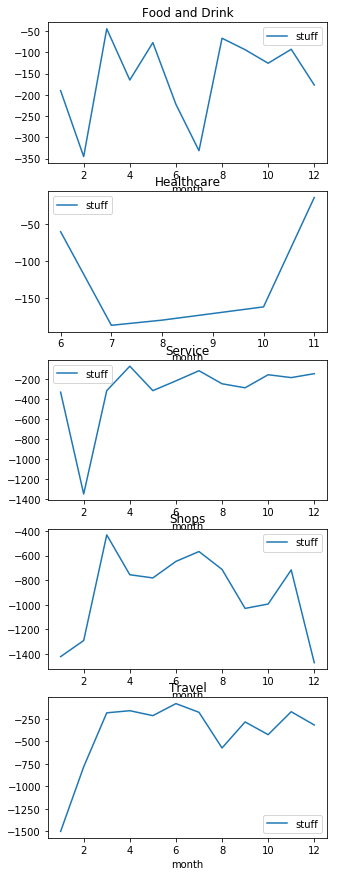

In [62]:
(fig, ax) = plt.subplots(nrows=5, figsize=(5,15))
df[df.category=='Food and Drink'].set_index('month').plot(ax=ax[0])
ax[0].set_title('Food and Drink')
df[df.category=='Healthcare'].set_index('month').plot(ax=ax[1])
ax[1].set_title('Healthcare')
df[df.category=='Service'].set_index('month').plot(ax=ax[2])
ax[2].set_title('Service')
df[df.category=='Shops'].set_index('month').plot(ax=ax[3])
ax[3].set_title('Shops')
df[df.category=='Travel'].set_index('month').plot(ax=ax[4])
ax[4].set_title('Travel')
None